# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# DESCARGAR HTML

url = "https://companiesmarketcap.com/tesla/revenue/"
response = requests.get(url).text

# Si se recibe un "403 Forbidden", reintentamos con el User-Agent adecuado
if '403 Forbidden' in response:
    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'}
    request = requests.get(url, headers = headers)
    time.sleep(10)
    response = request.text 
html_data = response 

In [3]:
# TRANSFORMAR EL HTML 

soup = BeautifulSoup(html_data,"html.parser")
soup

<!DOCTYPE html>

<html lang="en-US">
<head>
<title>Tesla (TSLA) - Revenue</title>
<meta charset="utf-8"/>
<link href="https://companiesmarketcap.com/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/img/icons/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
<link href="/img/icons/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
<link href="/img/icons/apple-icon-72x72.png" rel="apple-touch-icon" sizes="72x72"/>
<link href="/img/icons/apple-icon-76x76.png" rel="apple-touch-icon" sizes="76x76"/>
<link href="/img/icons/apple-icon-114x114.png" rel="apple-touch-icon" sizes="114x114"/>
<link href="/img/icons/apple-icon-120x120.png" rel="apple-touch-icon" sizes="120x120"/>
<link href="/img/icons/apple-icon-144x144.png" rel="apple-touch-icon" sizes="144x144"/>
<link href="/img/icons/apple-icon-152x152.png" rel="apple-touch-icon" sizes="152x152"/>
<link href="/img/icons/apple-icon-180x180.png" rel="apple-touch-icon" sizes="180x180"/>
<link href="/img/ico

In [4]:
# Buscar todas las tablas
table = soup.find("table")
table

<table class="table" style="width:100%">
<thead>
<tr>
<th>Year</th>
<th>Revenue</th>
<th>Change</th>
</tr>
</thead>
<tbody>
<tr><td><span class="year">2024</span> (TTM) <img class="ttm-dates-info-icon info-icon tooltip-title responsive-hidden" src="/img/info-icon-grey.svg" tooltip-position="right" tooltip-title="2 Oct 2023 - 30 Sep 2024"/></td><td>$97.15 B</td><td class="percentage-green">0.39%</td></tr><tr><td><span class="year">2023</span> <img class="ttm-dates-info-icon info-icon tooltip-title responsive-hidden" src="/img/info-icon-grey.svg" tooltip-position="right" tooltip-title="1 Jan 2023 - 31 Dec 2023"/></td><td>$96.77 B</td><td class="percentage-green">18.8%</td></tr><tr><td><span class="year">2022</span> <img class="ttm-dates-info-icon info-icon tooltip-title responsive-hidden" src="/img/info-icon-grey.svg" tooltip-position="right" tooltip-title="1 Jan 2022 - 31 Dec 2022"/></td><td>$81.46 B</td><td class="percentage-green">51.35%</td></tr><tr><td><span class="year">2021</span>

In [5]:
# Extraer los encabezados de la tabla 
headers = [header.text for header in table.find_all('th')]

# Extraer los renglones de la tabla
rows = [] 
for row in table.find_all('tr')[1:]: 
    cells = row.find_all('td') 
    cells = [cell.text.strip() for cell in cells] 
    rows.append(cells)


df = pd.DataFrame(rows, columns=headers)
df['Year'] = df['Year'].apply(lambda x: x.split()[0]) 
df['Revenue'] = df['Revenue'].replace(r'[\$, B]', '', regex=True).astype(float)
df['Change'] = df['Change'].replace(r'[\%,]', '', regex=True)
df['Change'] = pd.to_numeric(df['Change'], errors='coerce')
df

,Year,Revenue,Change
0,2024,97.15,0.39
1,2023,96.77,18.80
2,2022,81.46,51.35
3,2021,53.82,70.67
4,2020,31.53,28.31
5,2019,24.57,14.52
6,2018,21.46,82.51
7,2017,11.75,67.98
8,2016,7.00,73.01
9,2015,4.04,26.50


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     16 non-null     object 
 1   Revenue  16 non-null     float64
 2   Change   15 non-null     float64
dtypes: float64(2), object(1)
memory usage: 516.0+ bytes


In [7]:
df.sample(5)

,Year,Revenue,Change
9,2015,4.04,26.50
4,2020,31.53,28.31
10,2014,3.19,58.85
13,2011,0.20,74.95
11,2013,2.01,387.23


In [8]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     15 non-null     object 
 1   Revenue  15 non-null     float64
 2   Change   15 non-null     float64
dtypes: float64(2), object(1)
memory usage: 480.0+ bytes


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Revenue,15.0,29.031333,35.825751,0.11,2.60,11.75,42.675,97.15
Change,15.0,70.780000,92.902211,0.39,22.65,58.85,73.980,387.23


/tmp/ipykernel_3906/2868411774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype(int)


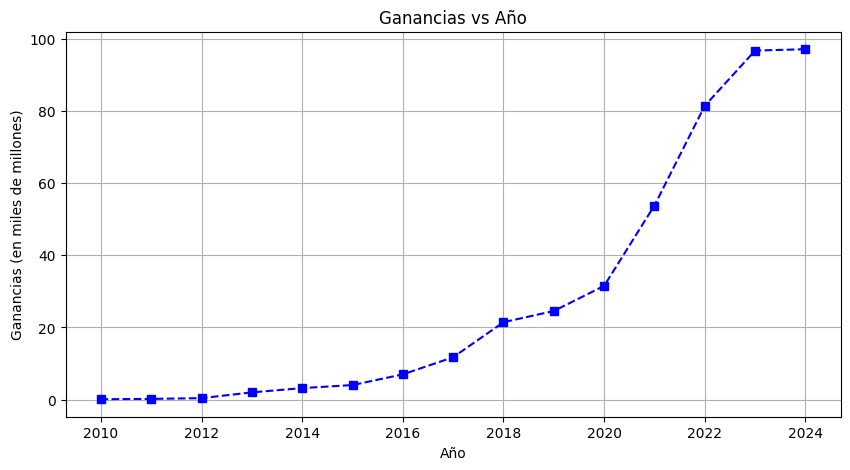

In [10]:
# Gráfica de las ganancias vs año
# Convierto el año a variable numérica
df['Year'] = df['Year'].astype(int)


plt.figure(figsize=(10, 5)) 
plt.plot(df['Year'], df['Revenue'], marker='s', linestyle='--', color='b')

plt.title('Ganancias vs Año') 
plt.xlabel('Año') 
plt.ylabel('Ganancias (en miles de millones)')


plt.grid(True) 
plt.show()
